In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax 
from jax import numpy as jnp
from flows.types import *
from flows.models.iresnet import InvertibleResNet
import optax
from flows.utils import *
from flows.models.linear import Linear
from flows.models.Composite import CompositeModel
from flows.utils import *
from numpy.polynomial.hermite import hermgauss
import itertools
from flows.bases import *
import matplotlib.pyplot as plt
from functools import partial
from flows.Bases import Hermite 
from flows.Bases import *
import flax.linen as nn
import sys 
from flows.models.Identity import Id as Identity 
import math
import flows
import pickle
jax.config.update("jax_log_compiles", True)

In [2]:
# Define plotting settings
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Computer Modern Roman'
fontsize_label = 18
fontsize_title = fontsize_label + 1
fontsize_legend = fontsize_label - 4
# size of the ticks 
plt.rcParams['xtick.labelsize'] = fontsize_label - 5
plt.rcParams['ytick.labelsize'] = fontsize_label - 5

# Initialize target functions

In [3]:
# Target function
def f1(x, w=0.):
    # First experiment in example 5.2
    try:
        x_ = x[:,0]
    except:
        x_ = x[0]
    out = (jnp.sin(jnp.abs(2*x_)))*jnp.exp(-(x_)**2/2)  
    return out

def f2(x, w=0.):
    # Second experiment in example 5.2    
    try:
        x_ = x[:,0]
    except:
        x_ = x[0]
    out = (jnp.sin(2*x_))*jnp.exp(-(x_)**4/2)  
    return out

f_grad = jax.vmap(jax.grad(f1))

# generate data
dim = 1
npoints_test = [100]*dim
# Generate Hermite quadratures
quad = [hermgauss(n) for n in npoints_test]
x = np.array([elem for elem in itertools.product(*[q[0] for q in quad])])
w = np.array([np.prod(elem) for elem in itertools.product(*[q[1] for q in quad])])
# Generate a denser grid for plotting
x1 = jnp.linspace(-8.,8.,5000)
x = x1
w = np.zeros_like(x)
dx = np.diff(x)
w[1:-1] = (dx[:-1] + dx[1:])/2
w[0] = dx[0]/2
w[-1] = dx[-1]/2
w *= jnp.exp(-x**2)
x = x[:,None]

### Plot target functions

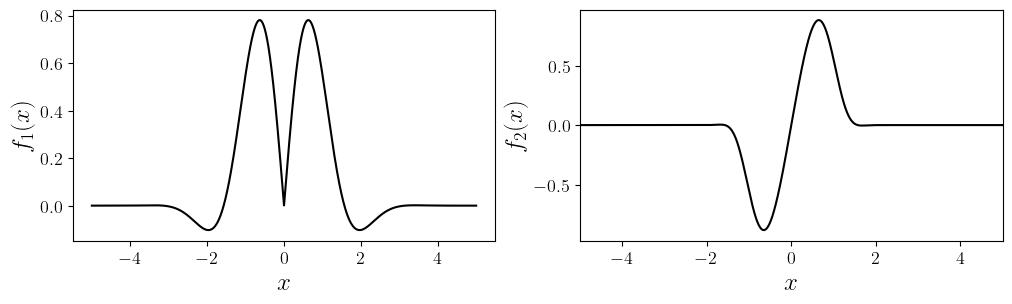

In [4]:
fig, axs = plt.subplots(1,2, sharey=False, figsize=(12,3))
x_test = np.linspace(-5., 5., 10000).reshape(-1,1)
axs[0].plot(x_test, f1(x_test, w), color='black')
axs[1].plot(x_test, f2(x_test, w), color='black')


axs[0].set_xlabel(r"$x$", fontsize=fontsize_label)
axs[1].set_xlabel(r"$x$", fontsize=fontsize_label)

axs[0].set_ylabel(r"$f_1(x)$", fontsize=fontsize_label)
axs[1].set_ylabel(r"$f_2(x)$", fontsize=fontsize_label)

plt.xlim(-5., 5.)
plt.show()

We now define Hermite basis functions

In [5]:
nmax = 15
n_basis = [nmax for _ in range(x.shape[1])]
w_basis = [1 for _ in range(x.shape[1])]
# Note that when we project we need to multiply by the weights of the basis
basis_no = Hermite.init_basis(n_basis, w_basis, nmax, orthotype=orthoType.n_ortho) # weights for generating non-orthonormal basis
basis_pr = Hermite.init_basis(n_basis, w_basis, nmax, orthotype=orthoType.proj) # 
#weights for generating the basis on which we project
basis_r = Hermite.init_basis(n_basis, w_basis, nmax, orthotype=orthoType.ortho) # 
psi_no = partial(Hermite.batch_basis_values, basis_no)
psi_pr = partial(Hermite.batch_basis_values, basis_pr)

psi_o = partial(Hermite.batch_basis_values, basis_r)  

def psi_pr(x):
    y = psi_no(x)
    n_basis = y.shape[1]
    for n in range(n_basis):
        y = y.at[:,n].set(y[:,n] * 1./((math.factorial(n)*2**n)*np.sqrt(jnp.pi)))
    return y
     #psi_no

#psi_pr = psi_no
# Important note. Set psi_pr to psi_no and this would work as well! 

psi_ev: [[  0.56418958  -4.51351667  17.91301928 ... -25.39138961  12.8657017
   -6.01532792]
 [  0.56418958  -4.5117109   17.89857602 ... -25.24447747  12.78466831
   -5.97427924]
 [  0.56418958  -4.50990513  17.88413855 ... -25.09834205  12.70410389
   -5.93348917]
 ...
 [  0.56418958   4.50990513  17.88413855 ...  25.09834205  12.70410389
    5.93348917]
 [  0.56418958   4.5117109   17.89857602 ...  25.24447747  12.78466831
    5.97427924]
 [  0.56418958   4.51351667  17.91301928 ...  25.39138961  12.8657017
    6.01532792]]
[ 6.07158669e-01 -2.64307685e-17 -2.14843020e-02  2.37303223e-17
 -9.96358113e-03  1.32556483e-18  9.19815349e-04 -1.38199537e-20
 -4.26616569e-05 -4.86400566e-21  1.49432044e-06  4.37011558e-23
 -4.61035739e-08  5.55046153e-24  1.30444809e-09 -8.00671921e-26]
L2 error of the approximation: 0.11694791935335135


upperbound 1.3434721714965483


[]

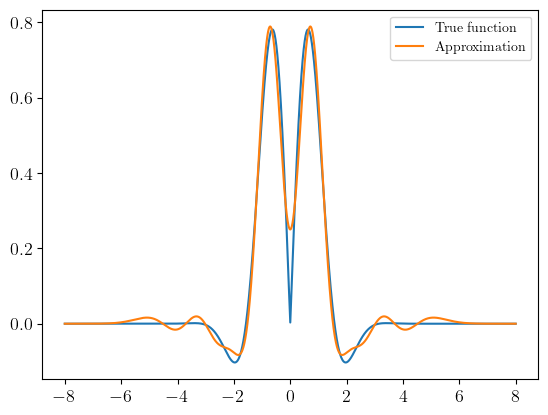

In [6]:
# Let's start compute the best approximation of $f$ in the basis $\psi_{no}$

def compute_coeff(x, w):
    true_func = f1(x,w)
    psi_ev = psi_pr(x)
    print(f"psi_ev: {psi_ev}")
    weight = jnp.exp(x[:,0]**2/2)
    #psi_ev = psi_ev*weight[:,None]

    approx_coeffs = jnp.einsum('j,jk,j,j->k', true_func, psi_ev, weight, w)
    #approx_coeffs = jnp.einsum('j,jk,j->k', true_func, psi_ev, w)
    
    return approx_coeffs

def l2_error(x, w, true_func, approx_func):
    weight = jnp.exp(x[:,0]**2)
    error = jnp.sqrt(jnp.einsum('i,i,i->', (true_func - approx_func)**2, weight, w))
    return error

def upperbound(x,w):
    true_func = f1(x,w)
    gradient = f_grad(x)[:,0]
    integrand1 = (1/np.sqrt(2))*x[:,0]*true_func
    integrand2 = (1/np.sqrt(2))*gradient
    weight = jnp.exp(x[:,0]**2)
    return jnp.sqrt(jnp.einsum('i,i,i->', (integrand1 + integrand2)**2, weight, w))

coeffs = compute_coeff(x, w)
print(coeffs)
approximating_func = lambda x, coeffs: jnp.einsum('k,jk,j->j', coeffs, psi_no(x), jnp.exp(-x[:,0]**2/2))
approximation = approximating_func(x, coeffs)
print('L2 error of the approximation:', l2_error(x, w, f1(x,w), approximation))
up_lin = upperbound(x,w)
print(f"upperbound {up_lin}")
plt.plot(x, f1(x, w), label='True function')
plt.plot(x, approximation, label='Approximation')
plt.legend()        
plt.plot()

Now we commpute the approximation for different values of N

In [7]:
# define the values of n

n_values = np.arange(5,45,5)
losses_l = []
size_basis = []
for n in n_values:
    nmax = n
    n_basis = [nmax for _ in range(x.shape[1])]
    w_basis = [1 for _ in range(x.shape[1])]
    # Note that when we project we need to multiply by the weights of the basis
    basis_no = Hermite.init_basis(n_basis, w_basis, nmax, orthotype=orthoType.n_ortho) # weights for generating non-orthonormal basis
    basis_pr = Hermite.init_basis(n_basis, w_basis, nmax, orthotype=orthoType.proj) # 
#weights for generating the basis on which we project
    basis_r = Hermite.init_basis(n_basis, w_basis, nmax, orthotype=orthoType.ortho) # 
    psi_no = partial(Hermite.batch_basis_values, basis_no)
    #psi_pr = psi_no#partial(Hermite.batch_basis_values, basis_pr)
    def psi_pr(x):
        y = psi_no(x)
        n_basis = y.shape[1]
        for n in range(n_basis):
            y = y.at[:,n].set(y[:,n] * 1./((math.factorial(n)*2**n)*np.sqrt(jnp.pi)))
        return y
    psi_o = partial(Hermite.batch_basis_values, basis_r)  
    coeffs = compute_coeff(x, w)
    approximation = approximating_func(x, coeffs)
    loss_l = l2_error(x, w, f1(x,w), approximation)
    print(f"n: {n}, L2 error: {loss_l}")
    losses_l.append(loss_l)
    size_basis.append(n)




psi_ev: [[   0.56418958   -4.51351667   17.91301928  -47.01579863   91.79246985
  -142.16637189]
 [   0.56418958   -4.5117109    17.89857602  -46.95848862   91.64208092
  -141.87281795]
 [   0.56418958   -4.50990513   17.88413855  -46.90122482   91.49187535
  -141.57974506]
 ...
 [   0.56418958    4.50990513   17.88413855   46.90122482   91.49187535
   141.57974506]
 [   0.56418958    4.5117109    17.89857602   46.95848862   91.64208092
   141.87281795]
 [   0.56418958    4.51351667   17.91301928   47.01579863   91.79246985
   142.16637189]]
n: 5, L2 error: 0.37746848194090804
psi_ev: [[   0.56418958   -4.51351667   17.91301928 ...  186.36847875
  -154.67544829  114.4219347 ]
 [   0.56418958   -4.5117109    17.89857602 ...  185.73652283
  -154.07996169  113.92782776]
 [   0.56418958   -4.50990513   17.88413855 ...  185.10642572
  -153.48649478  113.43562353]
 ...
 [   0.56418958    4.50990513   17.88413855 ...  185.10642572
   153.48649478  113.43562353]
 [   0.56418958    4.5117109   

psi_ev: [[  0.56418958  -4.51351667  17.91301928 ... -25.39138961  12.8657017
   -6.01532792]
 [  0.56418958  -4.5117109   17.89857602 ... -25.24447747  12.78466831
   -5.97427924]
 [  0.56418958  -4.50990513  17.88413855 ... -25.09834205  12.70410389
   -5.93348917]
 ...
 [  0.56418958   4.50990513  17.88413855 ...  25.09834205  12.70410389
    5.93348917]
 [  0.56418958   4.5117109   17.89857602 ...  25.24447747  12.78466831
    5.97427924]
 [  0.56418958   4.51351667  17.91301928 ...  25.39138961  12.8657017
    6.01532792]]
n: 15, L2 error: 0.11694791935335135
psi_ev: [[ 0.56418958 -4.51351667 17.91301928 ...  0.39395453 -0.13826379
   0.04545665]
 [ 0.56418958 -4.5117109  17.89857602 ...  0.39060958 -0.13700825
   0.04501613]
 [ 0.56418958 -4.50990513 17.88413855 ...  0.38729112 -0.13576336
   0.04457961]
 ...
 [ 0.56418958  4.50990513 17.88413855 ...  0.38729112  0.13576336
   0.04457961]
 [ 0.56418958  4.5117109  17.89857602 ...  0.39060958  0.13700825
   0.04501613]
 [ 0.564189

psi_ev: [[ 5.64189584e-01 -4.51351667e+00  1.79130193e+01 ... -1.10966232e-03
   2.85161799e-04 -6.90585294e-05]
 [ 5.64189584e-01 -4.51171090e+00  1.78985760e+01 ... -1.09671745e-03
   2.81630924e-04 -6.81514907e-05]
 [ 5.64189584e-01 -4.50990513e+00  1.78841386e+01 ... -1.08391476e-03
   2.78141252e-04 -6.72556869e-05]
 ...
 [ 5.64189584e-01  4.50990513e+00  1.78841386e+01 ...  1.08391476e-03
   2.78141252e-04  6.72556869e-05]
 [ 5.64189584e-01  4.51171090e+00  1.78985760e+01 ...  1.09671745e-03
   2.81630924e-04  6.81514907e-05]
 [ 5.64189584e-01  4.51351667e+00  1.79130193e+01 ...  1.10966232e-03
   2.85161799e-04  6.90585294e-05]]
n: 25, L2 error: 0.0748021506788837
psi_ev: [[ 5.64189584e-01 -4.51351667e+00  1.79130193e+01 ...  6.87689427e-07
  -1.31220892e-07  2.35307475e-08]
 [ 5.64189584e-01 -4.51171090e+00  1.78985760e+01 ...  6.76912527e-07
  -1.29037135e-07  2.31142605e-08]
 [ 5.64189584e-01 -4.50990513e+00  1.78841386e+01 ...  6.66294877e-07
  -1.26887615e-07  2.27047081e-0

n: 30, L2 error: 0.0626091348075039
psi_ev: [[ 5.64189584e-01 -4.51351667e+00  1.79130193e+01 ... -9.06858787e-11
   1.22006728e-11 -1.49321266e-12]
 [ 5.64189584e-01 -4.51171090e+00  1.78985760e+01 ... -8.87173651e-11
   1.19135809e-11 -1.45462381e-12]
 [ 5.64189584e-01 -4.50990513e+00  1.78841386e+01 ... -8.67886135e-11
   1.16327257e-11 -1.41694383e-12]
 ...
 [ 5.64189584e-01  4.50990513e+00  1.78841386e+01 ...  8.67886135e-11
   1.16327257e-11  1.41694383e-12]
 [ 5.64189584e-01  4.51171090e+00  1.78985760e+01 ...  8.87173651e-11
   1.19135809e-11  1.45462381e-12]
 [ 5.64189584e-01  4.51351667e+00  1.79130193e+01 ...  9.06858787e-11
   1.22006728e-11  1.49321266e-12]]
n: 35, L2 error: 0.05662856670918224


psi_ev: [[ 5.64189584e-01 -4.51351667e+00  1.79130193e+01 ...  1.00643035e-15
  -1.50530582e-17 -9.56976772e-18]
 [ 5.64189584e-01 -4.51171090e+00  1.78985760e+01 ...  9.59472369e-16
  -1.19074219e-17 -9.61287303e-18]
 [ 5.64189584e-01 -4.50990513e+00  1.78841386e+01 ...  9.14129516e-16
  -8.90948361e-18 -9.64614804e-18]
 ...
 [ 5.64189584e-01  4.50990513e+00  1.78841386e+01 ...  9.14129516e-16
   8.90948361e-18 -9.64614804e-18]
 [ 5.64189584e-01  4.51171090e+00  1.78985760e+01 ...  9.59472369e-16
   1.19074219e-17 -9.61287303e-18]
 [ 5.64189584e-01  4.51351667e+00  1.79130193e+01 ...  1.00643035e-15
   1.50530582e-17 -9.56976772e-18]]
n: 40, L2 error: 0.04983443265032697


Define a neural network

In [8]:
class MultipleResLin(nn.Module):
    number_of_layers: int
    dim: int

    def setup(self):
        self.models = [InvertibleResNet([[8,self.dim]], lip=0.9,
                                        svd=svdType.direct) for _ in range(self.number_of_layers)]
        #self.lin_models = [Linear([1.]*self.dim, [0.]*self.dim) for _ in range(self.number_of_layers)]
        self.lin_model = Linear([1.]*self.dim, [0.]*self.dim)
    
    @nn.compact
    def __call__(self, x, mode=evaluationMode.direct):
        
        if mode == evaluationMode.direct:
            x = self.lin_model(x, mode=mode)
            #for model_nl, model_l in zip(self.models, self.lin_models):
            for model_nl in self.models:
            #x = self.lin_model(x, mode=mode)
            #for model_nl in self.models:
                x = model_nl(x, mode=mode)
            #    x = model_l(x, mode=mode)
            return x
        else:
            for model_nl in reversed(self.models):
            
            #for model_nl, model_l in zip(reversed(self.models), reversed(self.lin_models)):
            #    x = model_l(x, mode=mode)
                x = model_nl(x, mode=mode)
            #x = self.lin_model(x, mode=mode)
            #"""
            x = self.lin_model(x, mode=mode)
            
            return x

In [9]:
@jax.jit
def compute_coeff(params, x, w):
    r = model.apply(params, x, mode=evaluationMode.inverse)
    true_func = f1(r,w)
    det = abs_det_jac_x(model, params, r, mode=evaluationMode.direct)
    psi_ev = (psi_pr(x))
    weight = jnp.exp(x[:,0]**2/2)  
    approx_coeffs = jnp.einsum('j,jk,j,j,j->k', true_func, psi_ev, w, weight, 1/det)
    return approx_coeffs
    
@jax.jit
def l2_error(params, x, w):    
    r = model.apply(params, x, mode=evaluationMode.direct)
    #det = abs_det_jac_x(model, params, r, mode=evaluationMode.direct)
    true_func = f1(x,w)
    psi_ev = psi_no(r)
    det = abs_det_jac_x(model, params, x, mode=evaluationMode.direct)
    approx_coeffs = compute_coeff(params, x, w)
    approx_func = jnp.einsum('k,jk,j,j->j', approx_coeffs, psi_ev, det, jnp.exp(-r[:,0]**2/2))
    error_values = (true_func - approx_func)**2
    #loss = jnp.mean(error_values)
    weight = jnp.exp(x[:,0]**2)
    loss = jnp.sqrt(jnp.einsum('i,i,i->', error_values, w, weight))
    return loss

def upperbound(x,w):
    r = model.apply(params, x, mode=evaluationMode.inverse)
    jac_r_ = jac_x(model, params, r, mode=evaluationMode.inverse)[:,0]
    jac_x_ = jac_x(model, params, x, mode=evaluationMode.inverse)[:,0]
    hess_r_ = hess_x(model, params, r, mode=evaluationMode.inverse)[:,0,0]
    
    true_func = f1(r)
    integrand1 = (1/np.sqrt(2))*x[:,0]*true_func
    gradient = f_grad(r)[:,0]
    integrand2 = (1/np.sqrt(2))*jac_x_*(gradient*jac_r_ + true_func*hess_r_)
    weight = jnp.exp(x[:,0]**2)
    return jnp.sqrt(jnp.einsum('i,i,i->', (integrand1 + integrand2)**2, weight, w))

nograd = lambda x: jax.lax.stop_gradient(x)
loss_grad_fn = jax.value_and_grad(l2_error)
loss_fn = l2_error 

@jax.jit
def update_params(carry, args):
    params, opt_state, loss = carry
    loss_val, grad = loss_grad_fn(params, *args)
    updates, opt_state = optx.update(grad, opt_state)
    params = optax.apply_updates(params, updates)
    return (params, opt_state, loss+loss_val), 0

In [10]:

learning_rate = 1e-3
n_epochs = 100 # we used 10k iterations
nmax = 10# works really good
n_basis = [nmax for _ in range(x.shape[1])]
w_basis = [1 for _ in range(x.shape[1])]
# Note that when we project we need to multiply by the weights of the basis
basis_no = Hermite.init_basis(n_basis, w_basis, nmax, orthotype=orthoType.n_ortho) # weights for generating non-orthonormal basis
basis_pr = Hermite.init_basis(n_basis, w_basis, nmax, orthotype=orthoType.proj) # 
#weights for generating the basis on which we project
psi_no = partial(Hermite.batch_basis_values, basis_no)
psi_pr = partial(Hermite.batch_basis_values, basis_pr)    
def psi_pr(x):
    y = psi_no(x)
    n_basis = y.shape[1]
    for n in range(n_basis):
        y = y.at[:,n].set(y[:,n] * 1./((math.factorial(n)*2**n)*np.sqrt(jnp.pi)))
    return y
model = MultipleResLin(1, x.shape[1])
params = model.init(jax.random.PRNGKey(0), x, mode=evaluationMode.direct)
optx = optax.adam(learning_rate=learning_rate)
opt_state = optx.init(params)
def plot(params, x, w):
    r = model.apply(params, x, mode=evaluationMode.direct)
    #det = abs_det_jac_x(model, params, r, mode=evaluationMode.direct)
    true_func = f(x,w)
    psi_ev = psi_no(r)
    det = abs_det_jac_x(model, params, x, mode=evaluationMode.direct)
    approx_coeffs = compute_coeff(params, x, w)
    approx_func = jnp.einsum('k,jk,j,j->j', approx_coeffs, psi_ev, det, jnp.exp(-r[:,0]**2/2))
    plt.plot(x, true_func, label='True function')
    plt.plot(x, approx_func, label='Approximation')
    plt.legend()
    plt.show()

for epoch in range(1,n_epochs):
    carry = (params, opt_state, 0)
    carry, _ = update_params(carry, (nograd(x), nograd(w)))
    params, opt_state, loss = carry 
    
    print(f"n: {nmax}, epoch: {epoch}, loss: {loss}")
    if epoch % 5000 == 0:
        plot(params, x, w)
        ub = upperbound(x,w)
        print(f"upperbound {ub}")


n: 10, epoch: 1, loss: 0.2563376276209623
n: 10, epoch: 2, loss: 0.2546435500979984
n: 10, epoch: 3, loss: 0.2530235644562946
n: 10, epoch: 4, loss: 0.25147925009138655
n: 10, epoch: 5, loss: 0.25001034072597944
n: 10, epoch: 6, loss: 0.24861375109291098
n: 10, epoch: 7, loss: 0.2472827288435371
n: 10, epoch: 8, loss: 0.24600697105020017
n: 10, epoch: 9, loss: 0.2447744688307692
n: 10, epoch: 10, loss: 0.24357445985009513
n: 10, epoch: 11, loss: 0.24239955547069814
n: 10, epoch: 12, loss: 0.2412459564752209
n: 10, epoch: 13, loss: 0.2401124028416728
n: 10, epoch: 14, loss: 0.2389994945113288
n: 10, epoch: 15, loss: 0.23790779762332198
n: 10, epoch: 16, loss: 0.23683707572612142
n: 10, epoch: 17, loss: 0.23578736902774697
n: 10, epoch: 18, loss: 0.23475858390527982
n: 10, epoch: 19, loss: 0.2337479901990034
n: 10, epoch: 20, loss: 0.2327535716842079
n: 10, epoch: 21, loss: 0.23177295920201355
n: 10, epoch: 22, loss: 0.23080126570243037
n: 10, epoch: 23, loss: 0.2298347766747988
n: 10, e

Use the learned basis with larger values of N

In [ ]:
# define the values of n 
#n_values = np.arange(5,75,10)
#n_values = np.arange(5,25,3)
losses_nl = []
size_basis = []
def compute_coeff_uj(params, x, w):
    r = model.apply(params, x, mode=evaluationMode.inverse)
    true_func = f1(r,w)
    det = abs_det_jac_x(model, params, r, mode=evaluationMode.direct)
    psi_ev = (psi_pr(x))
    weight = jnp.exp(x[:,0]**2/2)  
    approx_coeffs = jnp.einsum('j,jk,j,j,j->k', true_func, psi_ev, w, weight, 1/det)
    return approx_coeffs

   
def l2_error_uj(params, x, w):    
    r = model.apply(params, x, mode=evaluationMode.direct)
    #det = abs_det_jac_x(model, params, r, mode=evaluationMode.direct)
    true_func = f1(x,w)
    psi_ev = psi_no(r)
    det = abs_det_jac_x(model, params, x, mode=evaluationMode.direct)
    approx_coeffs = compute_coeff_uj(params, x, w)
    approx_func = jnp.einsum('k,jk,j,j->j', approx_coeffs, psi_ev, det, jnp.exp(-r[:,0]**2/2))
    #approximating_func = lambda x, coeffs: jnp.einsum('k,jk,j->j', coeffs, psi_no(x), jnp.exp(-x[:,0]**2/2))
    error_values = (true_func - approx_func)**2
    #loss = jnp.mean(error_values)
    weight = jnp.exp(x[:,0]**2)
    loss = jnp.sqrt(jnp.einsum('i,i,i->', error_values, w, weight))
    return loss
def plot_uj(params, x, w):
    r = model.apply(params, x, mode=evaluationMode.direct)
    #det = abs_det_jac_x(model, params, r, mode=evaluationMode.direct)
    true_func = f1(x,w)
    psi_ev = psi_no(r)
    det = abs_det_jac_x(model, params, x, mode=evaluationMode.direct)
    approx_coeffs = compute_coeff_uj(params, x, w)
    print(f"approx_coeffs {approx_coeffs}")
    approx_func = jnp.einsum('k,jk,j,j->j', approx_coeffs, psi_ev, det, jnp.exp(-r[:,0]**2/2))
    plt.plot(x, true_func, label='True function')
    plt.plot(x, approx_func, label='Approximation')
    plt.legend()
    plt.show()

for n in n_values:
    nmax = n
    n_basis = [nmax for _ in range(x.shape[1])]
    w_basis = [1 for _ in range(x.shape[1])]
    # Note that when we project we need to multiply by the weights of the basis
    basis_no = Hermite.init_basis(n_basis, w_basis, nmax, orthotype=orthoType.n_ortho) # weights for generating non-orthonormal basis
    basis_pr = Hermite.init_basis(n_basis, w_basis, nmax, orthotype=orthoType.proj) # 
    #weights for generating the basis on which we project
    psi_no = partial(Hermite.batch_basis_values, basis_no)
    psi_pr = partial(Hermite.batch_basis_values, basis_pr)    
    """
    def psi_pr(x):
        y = psi_no(x)
        n_basis = y.shape[1]
        for n in range(n_basis):
            y = y.at[:,n].set(y[:,n] * 1./((jax.scipy.special.factorial(n)*2**n)*jnp.sqrt(jnp.pi)))
        return y
    """
    loss = l2_error_uj(params, x, w)
    print(f"n: {n}, L2 error: {loss}")
    losses_nl.append(loss)
    size_basis.append(n)
    

Plot the empirical errors

In [ ]:
# plot losses nl and loss l 
loss_l_1 = np.load("losses_l_f1.npy")
loss_l_2 = np.load("losses_l_f2.npy")
loss_nl_1 = np.load("losses_nl_f1.npy")
loss_nl_2 = np.load("losses_nl_f2.npy")

fig, axs = plt.subplots(1,2, figsize=(10,3))
axs[0].plot(size_basis[1:], loss_l_1[1:], marker='o', color='r', label='Hermite basis')
axs[0].plot(size_basis[1:], loss_nl_1[1:], marker='x', color='b', label='perturbed Hermite basis')
axs[1].plot(size_basis[1:], loss_l_2[1:], marker='o', color='r', label='Hermite basis')
axs[1].plot(size_basis[1:], loss_nl_2[1:], marker='x', color='b', label='perturbed Hermite basis')
axs[0].set_title(r'$f_1$', fontsize=fontsize_label)
axs[1].set_title(r'$f_2$', fontsize=fontsize_label)

axs[0].set_xlabel("number of basis functions", fontsize=fontsize_label)
axs[1].set_xlabel("number of basis functions", fontsize=fontsize_label)

axs[0].set_ylabel(r"$L^2$ error", fontsize=fontsize_label, color='black')
axs[0].set_yscale('log')
axs[1].set_yscale('log')
axs[0].grid(True, which='major', linestyle='--', alpha=0.6)

axs[1].grid(True, which='major', linestyle='--', alpha=0.6)


axs[0].legend(fontsize=fontsize_legend)
#plt.savefig("convergence.pdf", dpi=300, bbox_inches='tight')
plt.show()

Now we plot the functions. repeating the same procedure for f2

In [ ]:
# plot the flow
# 
with open("params_f1.pkl", "rb") as f:
#with open("superGaussian_params.pkl", "rb") as f:
    params1 = pickle.load(f)
with open("params_f2.pkl", "rb") as f:
#with open("superGaussian_params.pkl", "rb") as f:
    params2 = pickle.load(f)

r1 = model.apply(params1, x_test, mode=evaluationMode.direct)
r2 = model.apply(params2, x_test, mode=evaluationMode.direct)
plt.figure(figsize=(4,4))
plt.plot(x_test, r1, label=r'$h_1$', color='blue')
plt.plot(x_test, r2, label=r'$h_2$', color='red')

plt.xlabel(r"$x$", fontsize=fontsize_label+3)
#axs[1].set_xlabel(r"$x$", fontsize=fontsize_label)

plt.legend(fontsize=fontsize_legend+3)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.savefig("flow.pdf", dpi=300, bbox_inches='tight')


det1 = abs_det_jac_x(model, params1, x, mode=evaluationMode.direct)
inv_det1 = abs_det_jac_x(model, params1, x, mode=evaluationMode.inverse) 
det2 = abs_det_jac_x(model, params2, x, mode=evaluationMode.direct)
inv_det2 = abs_det_jac_x(model, params2, x, mode=evaluationMode.inverse)
print(f"max and min det1 are: {jnp.amax(det1)} and {1/jnp.amax(inv_det1)}")

print(f"max and min det2 are: {jnp.amax(det2)} and {1/jnp.amax(inv_det2)}")
